In [5]:
import os 
import re
from scipy import ndimage, misc
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dropout,Dense, Convolution2DTranspose, UpSampling2D, add, Input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
import cv2
import glob
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

In [2]:
face_images = glob.glob('lfw/**/*.jpg') 
print(len(face_images)) 

13233


In [3]:
from tqdm.notebook import tqdm
from multiprocessing import Pool
# progress = tqdm(total=len(face_images), position=0)

import read_image
p = Pool(10)
img_array = p.map(read_image.read,face_images)

In [6]:
with open('img_array.pickle','wb') as f:
    pickle.dump(img_array, f)

In [6]:
with open('img_array.pickle','rb') as f:
    img_array = pickle.load(f)

In [7]:
all_images = np.array(img_array)

In [8]:
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [9]:
def pixalate_image(image, scale_percent = 40):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    # scale back to original size
    width = int(small_image.shape[1] * 100 / scale_percent)
    height = int(small_image.shape[0] * 100 / scale_percent)
    dim = (width, height)

    low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

    return low_res_image

In [9]:
input_img = Input(shape=(256,256,3))
l1 = Conv2D(64,(3,3), activation='relu', activity_regularizer=regularizers.l1(10e-10), padding='same')(input_img)
l2 = Conv2D(64,(3,3), activation='relu', activity_regularizer=regularizers.l1(10e-10), padding='same')(l1)
l3 = MaxPooling2D(padding='same', pool_size=(2,2))(l2)
l4 = Conv2D(128,(3,3), activation='relu', activity_regularizer=regularizers.l1(10e-10), padding='same')(l3)
l5 = Conv2D(128,(3,3), activation='relu', activity_regularizer=regularizers.l1(10e-10), padding='same')(l4)
l6 = MaxPooling2D(padding='same', pool_size=(2,2))(l5)
l7 = Conv2D(256,(3,3), activation='relu', activity_regularizer=regularizers.l1(10e-10), padding='same')(l6)
encoder = Model(input_img,l7)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 128)       0     

In [10]:
train_x_px = []

for i in range(train_x.shape[0]):
    temp = pixalate_image(train_x[i,:,:,:])
    train_x_px.append(temp)

train_x_px = np.array(train_x_px)

val_x_px = []

for i in range(val_x.shape[0]):
    temp = pixalate_image(val_x[i,:,:,:])
    val_x_px.append(temp)

val_x_px = np.array(val_x_px)

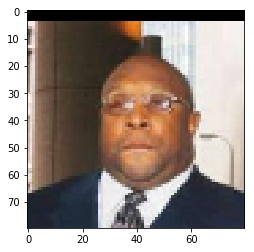

In [13]:
plt.imshow(train_x[100])

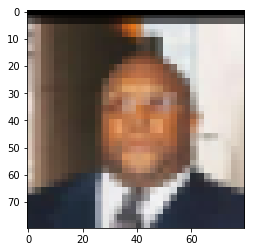

In [14]:
plt.imshow(train_x_px[100])

In [16]:
#encoder
input_img = Input(shape=(80,80,3))
l1 = Conv2D(64,(3,3), activation='relu', activity_regularizer=regularizers.l1(10e-10), padding='same')(input_img)
l2 = Conv2D(64,(3,3), activation='relu', activity_regularizer=regularizers.l1(10e-10), padding='same')(l1)
l3 = MaxPooling2D(padding='same', pool_size=(2,2))(l2)
l4 = Conv2D(128,(3,3), activation='relu', activity_regularizer=regularizers.l1(10e-10), padding='same')(l3)
l5 = Conv2D(128,(3,3), activation='relu', activity_regularizer=regularizers.l1(10e-10), padding='same')(l4)
l6 = MaxPooling2D(padding='same', pool_size=(2,2))(l5)
l7 = Conv2D(256,(3,3), activation='relu', activity_regularizer=regularizers.l1(10e-10), padding='same')(l6)

In [17]:
#decoder
l8 = UpSampling2D()(l7)
l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)
l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l13)
l15 = add([l14, l2])
decoded = Conv2D(3, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [19]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('model1.h5',save_best_only=True)

In [ ]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=100,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper, model_checkpoint], verbose=1)

Train on 10586 samples, validate on 2647 samples
Epoch 1/100
 1632/10586 [===>..........................] - ETA: 57:42 - loss: 0.0470 - accuracy: 0.5494

In [2]:
autoencoder = tf.keras.models.load_model('./model1.h5')

In [11]:
predictions = autoencoder.predict(val_x_px)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


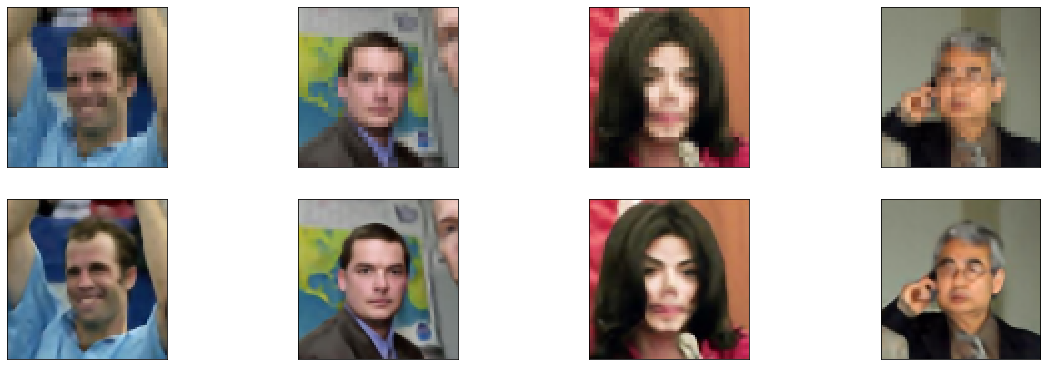

In [12]:
n = 4
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


plt.show()

In [15]:
results = autoencoder.evaluate(val_x_px, val_x,verbose=0)
print('loss, accuracy', results)

loss, accuracy [0.002109537353671589, 0.93370223]
